In [1]:
!pip install keras

In [2]:
import numpy as np

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

import keras.backend as K
from keras.layers import Activation, Input

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('classic')


Using TensorFlow backend.


### Loading data (Olivetti faces)

In [0]:
data_obj = fetch_olivetti_faces()

X = data_obj['data']
X = 1.0 * (X > 0.5)

y = data_obj['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=0)


### RBM definitions

$$E(v, h) = vWh$$

$$P(v, h) = \frac{e^{-E(v, h)}}{\sum_{u, g}e^{-E(u, g)}}$$

In [0]:
def across_layer_probabilities(W, input_layer):
  energy = K.dot(input_layer, W)
  return Activation('sigmoid')(energy)


def configuration_goodness_gradient(visible, hidden):
  """
  Gradient of (negative) energy 
  """
  n_samples_norm = K.cast(1 / K.shape(visible)[0], K.floatx())
  return - n_samples_norm * K.dot(
      K.transpose(visible),
      hidden,
  )


def sample_bernoulli(probas):
  uniform_samples = probas * K.random_uniform(shape=K.shape(probas))
  bernoulli_samples = K.greater(
    1 - probas,
    uniform_samples
  )
  return K.cast(bernoulli_samples, K.floatx())


def sample_from_other(W, other):
  """
  Sample hidden given visible or the other way around
  """
  proba = across_layer_probabilities(W, other)
  return sample_bernoulli(proba)


def cd1_variables(W, visible):
  hidden0 = K.identity(sample_from_other(W, visible), name='hidden0')
  
  visible_proba1 = across_layer_probabilities(K.transpose(W), hidden0)
  visible1 = K.identity(sample_bernoulli(visible_proba1), name='visible1')
  
  hidden1 = K.identity(sample_from_other(W, visible1), name='hidden1')

  return hidden0, visible1, hidden1


def cd1(W, visible):
  hidden0, visible1, hidden1 = cd1_variables(W, visible)
  goodness_gradient0 = configuration_goodness_gradient(visible, hidden0)
  goodness_gradient1 = configuration_goodness_gradient(visible1, hidden1)
  
  return - goodness_gradient0 + goodness_gradient1


def update_weights(W, delta):
  K.set_weights(W, delta)

### RBM setup

In [0]:
n_visible = X_train.shape[1]
n_hidden = 1000

W_in = K.variable(np.random.randn(n_visible, n_hidden) / 100)
visible_shape = (n_visible,)
visible_in = Input(shape=visible_shape)

cd = cd1(W_in, visible_in)

In [0]:
lr = 0.02

train_op = K.function(
    inputs=[visible_in],
    outputs=[],
    updates=[K.update(W_in, W_in - lr *cd)])

In [7]:
print(K.eval(W_in))

[[-0.01386624  0.00601599 -0.00943544 ..., -0.00412699 -0.01679478
  -0.00237199]
 [ 0.00979466 -0.01246592  0.00286995 ..., -0.01607858  0.00234078
   0.00759136]
 [ 0.00062093 -0.00443075 -0.01385287 ..., -0.00199012  0.00144474
  -0.01050046]
 ..., 
 [-0.016054   -0.00393365  0.0035759  ...,  0.0177048   0.00383936
  -0.0017164 ]
 [-0.00179664 -0.00161328 -0.00375551 ...,  0.01067746 -0.00776447
   0.00585591]
 [-0.00776149 -0.00172588 -0.0025685  ...,  0.003182    0.00837587
  -0.00462865]]


In [8]:
%%time

minibatch_size = 64
n_epochs = 1000

for __ in range(n_epochs):
  for i in range(X_train.shape[0] // minibatch_size):
    minibatch = X_train[i * minibatch_size:(i+1) * minibatch_size]
    train_op([minibatch])

CPU times: user 18.7 s, sys: 6.32 s, total: 25.1 s
Wall time: 28.2 s


In [9]:
print(K.eval(W_in))

[[ 0.03144624 -0.24179778 -0.03693542 ...,  0.02993549  0.00164271
   0.05512797]
 [ 0.04479463 -0.29902995  0.10255738 ...,  0.01485891  0.02640327
   0.03665384]
 [ 0.0403084  -0.25068212 -0.07979031 ...,  0.03394736  0.03050722
   0.0644995 ]
 ..., 
 [-0.0013665  -0.16955754 -0.11236151 ...,  0.03207979  0.02352685
  -0.0029664 ]
 [ 0.01539086 -0.11505076 -0.05938046 ...,  0.03911495  0.01817301
   0.03866838]
 [-0.00151149  0.16796198 -0.010381   ...,  0.02443199  0.03462585
   0.03162133]]


In [0]:
sample_hidden_from_visible = K.function(
  inputs=[visible_in],
  outputs=[sample_from_other(W_in, visible_in)]
)

hidden_input = Input(shape=(n_hidden,))
sample_visible_from_hidden = K.function(
  inputs=[hidden_input],
  outputs=[sample_from_other(K.transpose(W_in), hidden_input)]
)

In [0]:
[sampled_hidden] = sample_hidden_from_visible([X_test])
[sampled_visible] = sample_visible_from_hidden([sampled_hidden])

### Show reconstructed face

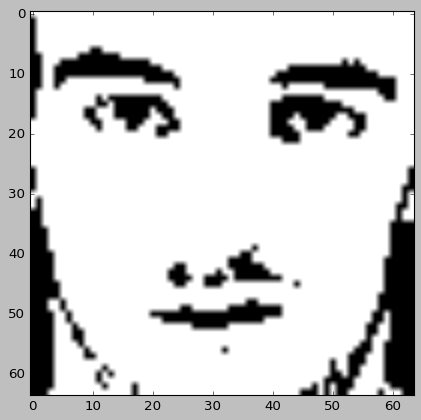

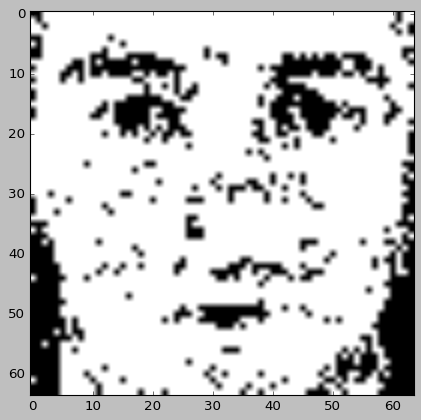

In [12]:
plt.imshow(X_test[1].reshape(64, 64), cmap='gray')
plt.show()
plt.imshow(sampled_visible[1].reshape(64, 64), cmap='gray')
plt.show()